In [1]:
#mouting drive....
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#required libraries
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import csv
from random import sample
import os
import math
from sklearn import preprocessing
from scipy.spatial.distance import cityblock
from scipy.spatial.distance import cdist
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster

sns.set_style('darkgrid')

In [3]:
#loading data
df = pd.read_csv('/content/drive/MyDrive/football_data.csv')

In [4]:
#checking whether data loaded correctly
df.head()

,Unnamed: 0,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause,Unnamed: 60
0,0,158023,L. Messi,31,Argentina,94,94,FC Barcelona,€110.5M,€565K,...,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M,NaN
1,1,20801,Cristiano Ronaldo,33,Portugal,94,94,Juventus,€77M,€405K,...,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M,NaN
2,2,190871,Neymar Jr,26,Brazil,92,93,Paris Saint-Germain,€118.5M,€290K,...,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M,NaN
3,3,193080,De Gea,27,Spain,91,93,Manchester United,€72M,€260K,...,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M,NaN
4,4,192985,K. De Bruyne,27,Belgium,91,92,Manchester City,€102M,€355K,...,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M,NaN


**Data Cleaning**

In [5]:
#viewing the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 61 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Nationality               18207 non-null  object 
 5   Overall                   18207 non-null  int64  
 6   Potential                 18207 non-null  int64  
 7   Club                      17966 non-null  object 
 8   Value                     18207 non-null  object 
 9   Wage                      18207 non-null  object 
 10  Special                   18207 non-null  object 
 11  Preferred Foot            18159 non-null  object 
 12  International Reputation  18159 non-null  object 
 13  Weak Foot                 18159 non-null  float64
 14  Skill 

In [6]:
#dropping columns that never be used....
df = df.drop(columns=['ID','Name','Unnamed: 0','Unnamed: 60','Joined','Loaned From','Contract Valid Until','Release Clause'])

In [7]:
#checking number of null values in each attribute..
df.isnull().sum()

Age                           0
Nationality                   0
Overall                       0
Potential                     0
Club                        241
Value                         0
Wage                          0
Special                       0
Preferred Foot               48
International Reputation     48
Weak Foot                    48
Skill Moves                  48
Work Rate                    48
Body Type                    48
Real Face                    48
Position                     60
Jersey Number                60
Height                       48
Weight                       48
Crossing                     51
Finishing                    48
HeadingAccuracy              48
ShortPassing                 48
Volleys                      48
Dribbling                    48
Curve                        48
FKAccuracy                   48
LongPassing                  48
BallControl                  48
Acceleration                 48
SprintSpeed                  48
Agility 

In [8]:
#dropping the 51 rows as 48 rows elements were NULL.. 
df =  df.dropna(subset=['Crossing'])

In [9]:
#filling the catergorical attributes null values with the "missing" value
df['Club'] = df['Club'].fillna('Missing')
df['Position'] = df['Position'].fillna('Missing')
df['Jersey Number'] = df['Jersey Number'].fillna('Missing')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

**Categorical Data cleaning and transformation**

In [10]:
df['Preferred Foot'].unique()

array(['Left', 'Right', '2006', '1876', '1879', '1743', '1660', '1449',
       '1710', '1740', '1798', '1701', '1646', '1455', '1348', '1599',
       '1535', '1471', '1424', '1580', '1337', '1206', '1486', '1402',
       '1392', '1453', '1281'], dtype=object)

In [11]:
#calculating the number of each unique item present
item_counts = df['Preferred Foot'].value_counts()
print(item_counts)

Right    13925
Left      4206
1348         1
1453         1
1392         1
1402         1
1486         1
1206         1
1337         1
1580         1
1424         1
1471         1
1535         1
1599         1
1455         1
1646         1
1701         1
1798         1
1740         1
1710         1
1449         1
1660         1
1743         1
1879         1
1876         1
2006         1
1281         1
Name: Preferred Foot, dtype: int64


In [12]:
#remaining data was noise we were dropping those rows
df = df[(df['Preferred Foot']=='Left') | (df['Preferred Foot']=='Right') ] 

In [13]:
df['Work Rate'].unique()

array(['Medium/ Medium', 'High/ Low', 'High/ Medium', 'High/ High',
       'Medium/ High', 'Medium/ Low', 'Low/ High', 'Low/ Medium',
       'Low/ Low'], dtype=object)

In [14]:
df['Body Type'].unique()   

array(['Messi', 'C. Ronaldo', 'Neymar', 'Lean', 'Normal', 'Courtois',
       'Stocky', 'PLAYER_BODY_TYPE_25', 'Shaqiri', 'Akinfenwa'],
      dtype=object)

In [15]:
#calculating the number of each unique item present
item_counts = df['Body Type'].value_counts()
print(item_counts)

Normal                 10584
Lean                    6402
Stocky                  1138
Messi                      1
C. Ronaldo                 1
Neymar                     1
Courtois                   1
PLAYER_BODY_TYPE_25        1
Shaqiri                    1
Akinfenwa                  1
Name: Body Type, dtype: int64


In [16]:
#remaining data was noise we were dropping those rows
df = df[(df['Body Type']=='Normal') | (df['Body Type']=='Lean') | (df['Body Type']=='Stocky') ] 

In [17]:
item_counts = df['Body Type'].value_counts()
print(item_counts)

Normal    10584
Lean       6402
Stocky     1138
Name: Body Type, dtype: int64


In [18]:
df['Real Face'].unique()

array(['Yes', 'No'], dtype=object)

In [19]:
df['Value'].describe()

count     18124
unique      214
top       €1.1M
freq        431
Name: Value, dtype: object

In [20]:
#the value column have the money in millions we converted into numerical.....
def convert_currency(x):
  if(x[-1] == 'M'):
    y = x[:-1]
    y = float(y)
    return y*100000
  elif(x[-1] == 'K'):
    y = x[:-1]
    y = float(y)
    return y*1000
  else:
    return float(x)
df['Value'] = df['Value'].apply(lambda x: x.replace('€',''))
df = df[df['Value'] != 'https://cdn.sofifa.org/teams/2/light/112429.png']
df['Value'] = df['Value'].apply(convert_currency)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [21]:
df['Wage'].describe()

count     18124
unique      140
top         €1K
freq       4867
Name: Wage, dtype: object

In [22]:
#similar to the above so we change the values..
df['Wage'] = df['Wage'].apply(lambda x: x.replace('€',''))
df['Wage'] = df['Wage'].apply(convert_currency)

In [23]:
df['Height'].describe()

count     18124
unique       21
top         6'0
freq       2877
Name: Height, dtype: object

In [24]:
#converting height into centimeters
conversions = [30.48, 2.54]
df['Height'] = df['Height'].apply(lambda x: pd.Series(map(int, x.split("'"))).dot(conversions))

In [25]:
df['Weight'].describe()

count      18124
unique        56
top       165lbs
freq        1479
Name: Weight, dtype: object

In [26]:
#removing the metric present in the data
df['Weight'] = df['Weight'].apply(lambda x: float(x[:-3]))

In [27]:
df['Crossing'].unique()

array(['17', '93', '81', '86', '77', '66', '13', '62', '88', '55', '84',
       '68', '82', '75', '15', '70', '58', '52', '90', '79', '64', '87',
       '60', '12', '69', '46', '30', '80', '11', '78', '57', '83', '85',
       '20', '73', '53', '72', '36', '44', '45', '40', '27', '76', '63',
       '65', '48', '61', '47', '89', '19', '49', '9', '71', '74', '24',
       '18', '38', '92', '56', '67', '35', '25', '50', '14', '29', '10',
       '42', '54', '59', '91', '51', '43', '33', '34', '16', '39', '28',
       '8', '21', '23', '41', '32', '37', '31', '22', '7', '26', '6', '5'],
      dtype=object)

In [28]:
df['Special'].unique()

array(['1471', '2281', '2142', ..., '778', '738', '731'], dtype=object)

In [29]:
df['International Reputation'].unique()

array(['4', '5', '3', '2', '1'], dtype=object)

In [30]:
#as the values in the above is just numbers we converted them to int...
df['International Reputation'] = df['International Reputation'].astype('int')
df['Special'] = df['Special'].astype('int')
df['Crossing'] = df['Crossing'].astype('int')

In [31]:
#conversion of each of the categorical attribute into numerical
for column in df.select_dtypes(include=['object']):
     label_encoder = preprocessing.LabelEncoder()
     df[column]= label_encoder.fit_transform(df[column])

**Numerical Data cleaning and transformation**

In [32]:
df.describe()

,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,International Reputation,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,1.812400e+04,18124.000000,18124.000000,18124.000000,18124.000000,...,18124.000000,18124.000000,18124.000000,18124.000000,18124.000000,18124.00000,18124.000000,18124.000000,18124.000000,18124.000000
mean,25.119896,76.223019,66.250883,71.322445,325.278802,4.759380e+05,9659.953653,1597.903608,0.768153,1.112392,...,48.554182,58.648422,47.282995,47.702715,45.666023,16.61631,16.390973,16.229585,16.388490,16.708618
std,4.669999,47.840277,6.895577,6.120097,187.156889,5.259718e+05,21187.422565,272.744373,0.422024,0.390110,...,15.702143,11.421230,19.910224,21.672198,21.297572,17.69308,16.903332,16.501406,17.032217,17.955911
min,16.000000,0.000000,46.000000,48.000000,0.000000,0.000000e+00,0.000000,731.000000,0.000000,1.000000,...,5.000000,3.000000,3.000000,2.000000,3.000000,1.00000,1.000000,1.000000,1.000000,1.000000
25%,21.000000,35.000000,62.000000,67.000000,163.000000,1.800000e+05,1000.000000,1457.000000,1.000000,1.000000,...,39.000000,51.000000,30.000000,27.000000,24.000000,8.00000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,59.000000,66.000000,71.000000,329.000000,3.700000e+05,3000.000000,1635.000000,1.000000,1.000000,...,49.000000,60.000000,53.000000,55.000000,52.000000,11.00000,11.000000,11.000000,11.000000,11.000000
75%,28.000000,123.000000,71.000000,75.000000,485.000000,6.500000e+05,9000.000000,1787.000000,1.000000,1.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.00000,14.000000,14.000000,14.000000,14.000000
max,45.000000,163.000000,91.000000,95.000000,650.000000,1.020000e+07,455000.000000,2346.000000,1.000000,5.000000,...,92.000000,93.000000,94.000000,93.000000,91.000000,90.00000,92.000000,91.000000,90.000000,94.000000


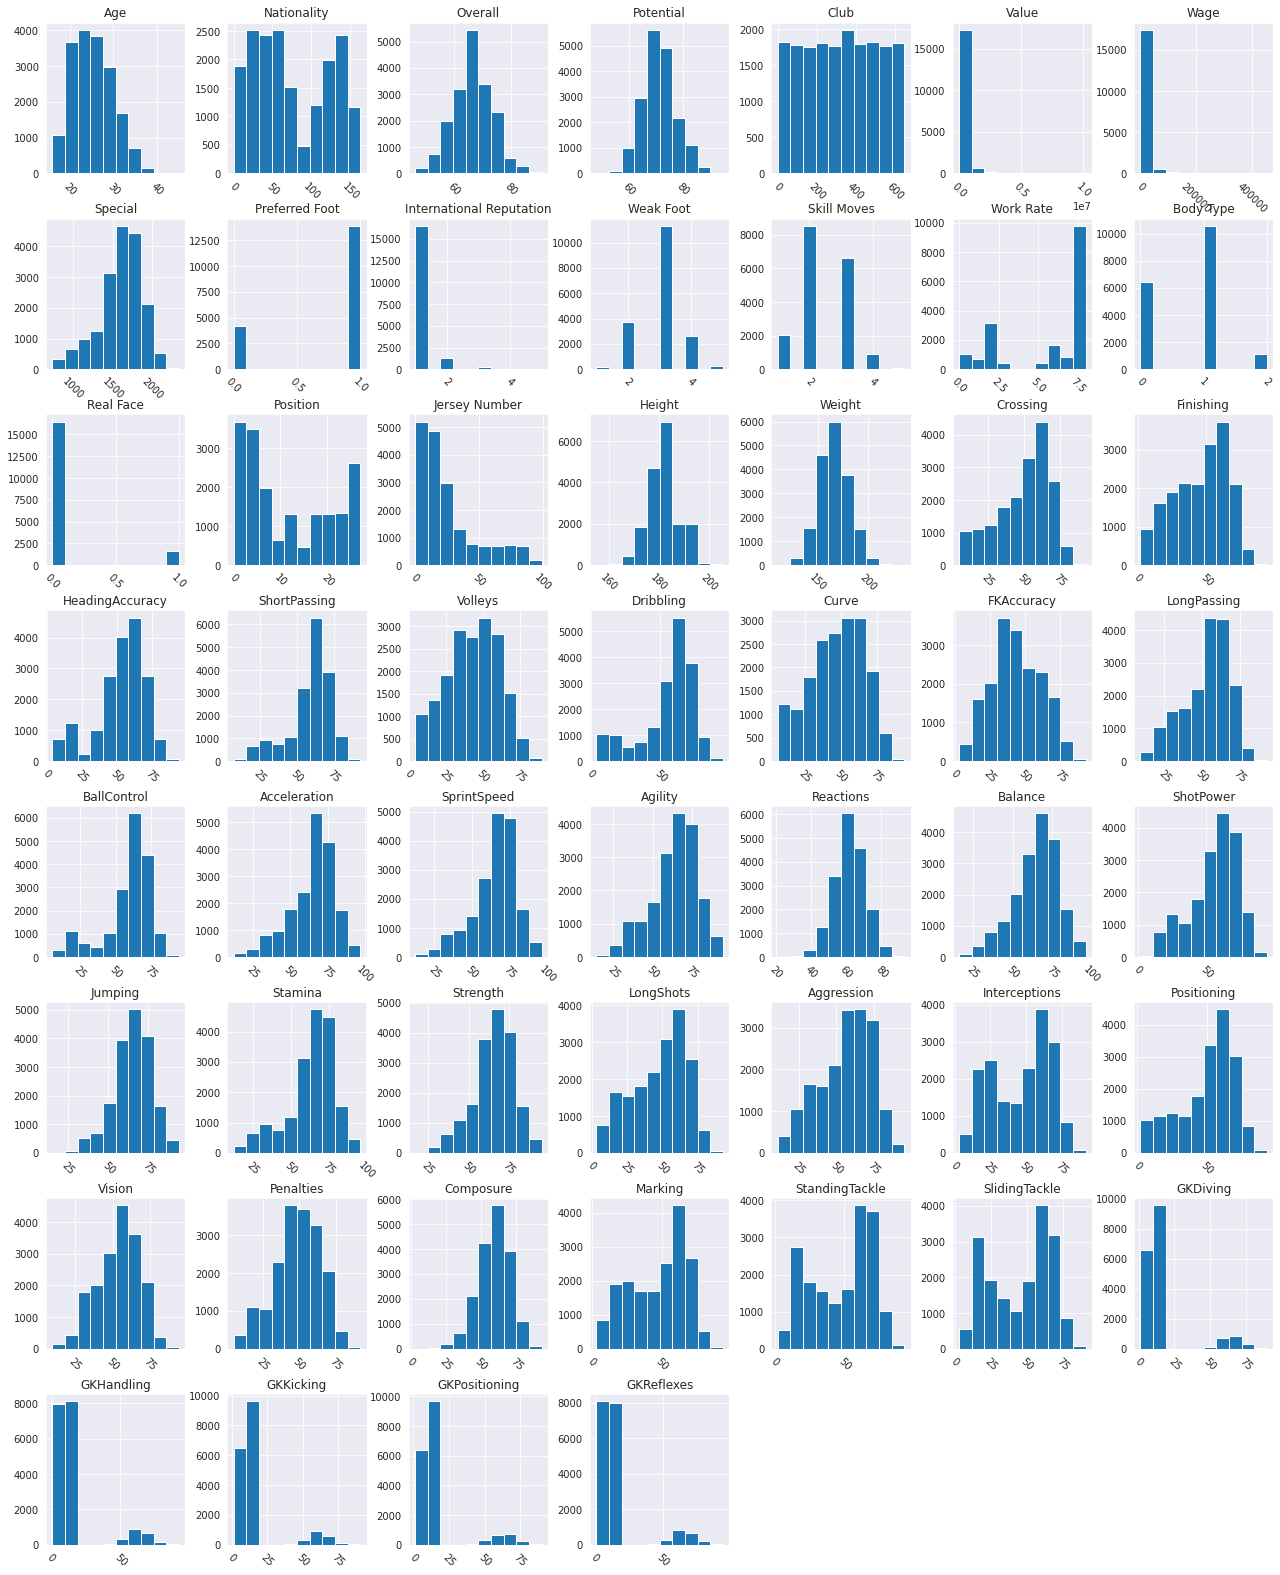

In [33]:
df.hist(figsize= (22,28),xrot=-45)
plt.show()

In [34]:
item_counts = df['GKHandling'].value_counts()
print(item_counts)

10.0    1627
11.0    1594
12.0    1591
7.0     1583
14.0    1580
        ... 
33.0       1
87.0       1
92.0       1
25.0       1
44.0       1
Name: GKHandling, Length: 69, dtype: int64


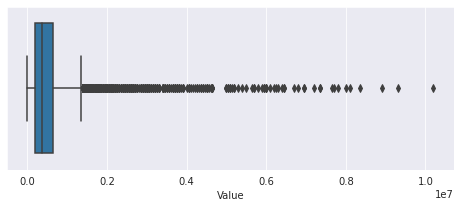

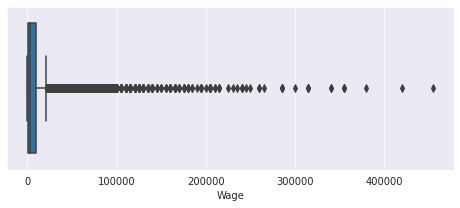

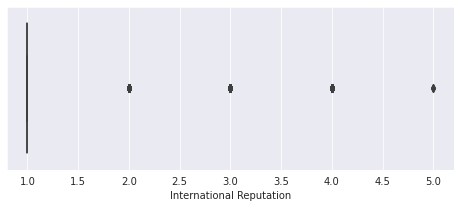

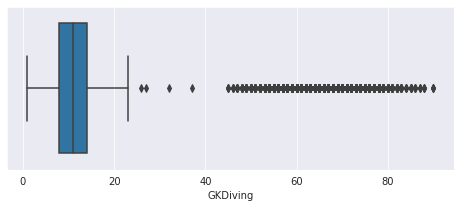

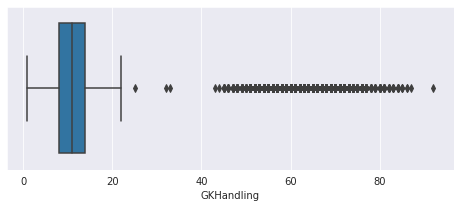

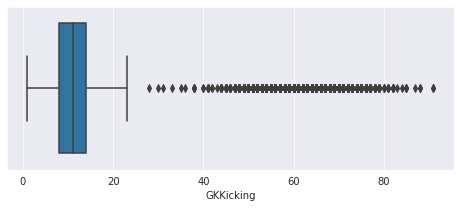

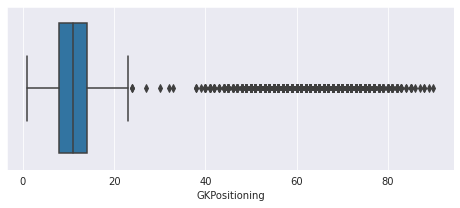

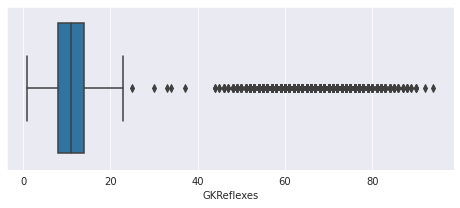

In [35]:
#box plot to confirm the outliers...
cls = ['Value','Wage','International Reputation','GKDiving','GKHandling','GKKicking',	'GKPositioning',	'GKReflexes']
for c in cls:
  f = plt.figure()
  f.set_figwidth(8)
  f.set_figheight(3)
  sns.boxplot(x=df[c])

# Agglomerative clustering

In [36]:
#adding a new column to store the cluster that it belong...
df['cluster_num'] = -1

In [37]:
#converting pandas dataframe to numpy array....
data = np.array(df)
data.shape

(18124, 54)

In [38]:

def AgglomerativeCluster(n,data,linkage):
  clustering = AgglomerativeClustering(n_clusters = n,linkage=linkage).fit(data)
  return clustering.labels_

#### Minimum distance (Single-Linkage)

In [39]:
# AgglomerativeCluster(3,data,'single')
Z = linkage(data, 'single')

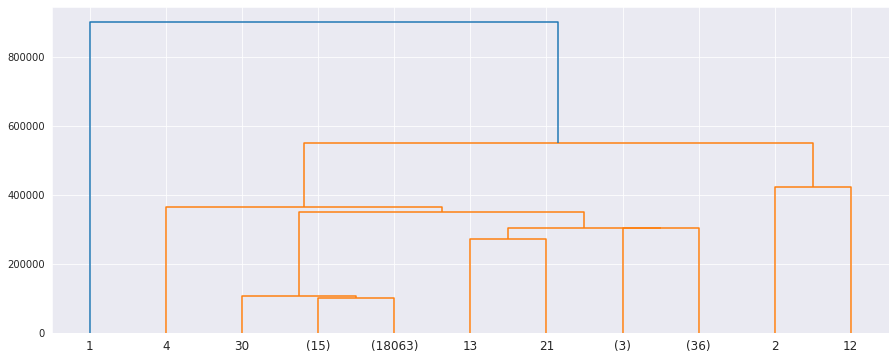

In [40]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
dn = dendrogram(Z,p=5,truncate_mode='level')

#### Maximum distance (Complete-Linkage)

In [41]:
# AgglomerativeCluster(3,data,'complete')
Z = linkage(data, 'complete')

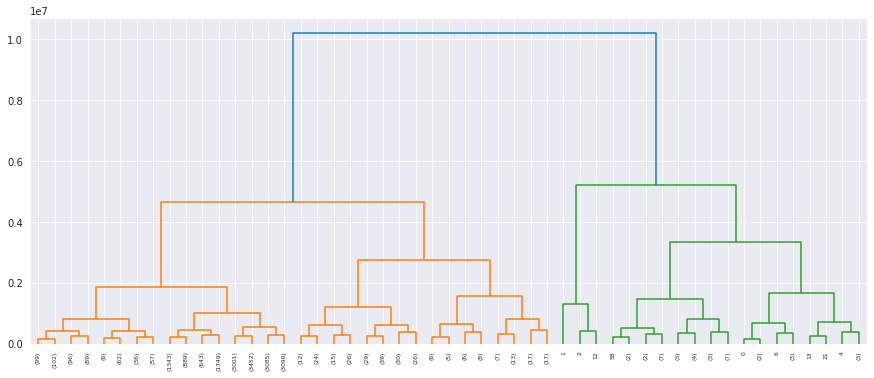

In [42]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
dn = dendrogram(Z,p=5,truncate_mode='level')

#### Average distance (Average-Linkage)

In [43]:
# AgglomerativeCluster(3,data,'average')
Z = linkage(data, 'average')

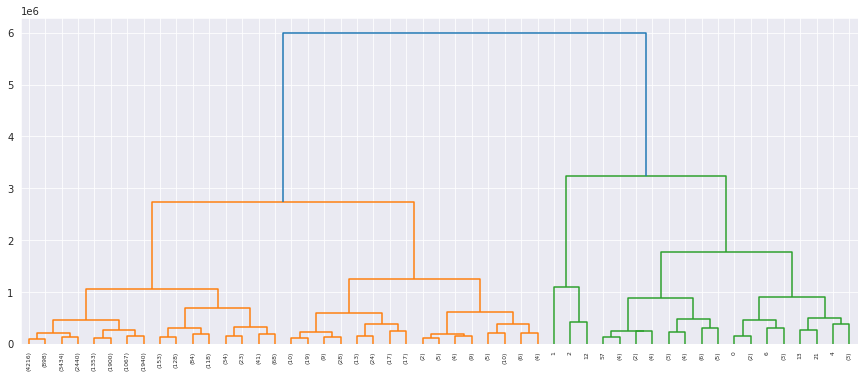

In [44]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
dn = dendrogram(Z,p=5,truncate_mode='level')

#### Mean distance

In [45]:
Z = linkage(data, 'centroid')

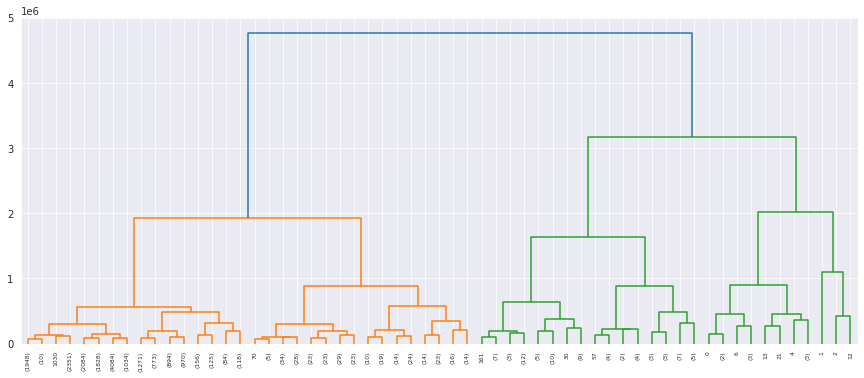

In [46]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)
dn = dendrogram(Z,p=5,truncate_mode='level')

https://www.kaggle.com/code/ellecf/visualizing-multidimensional-clusters

In [69]:
labels = fcluster(Z, t=2100000, criterion='distance')
np.unique(labels)

array([1, 2, 3], dtype=int32)

In [70]:
labels = pd.Series(labels)

In [72]:
labels.value_counts()

1    18031
2       77
3       16
dtype: int64

In [63]:
labeled_data = df.copy()
labeled_data.reset_index(inplace = True)
labeled_data['labels'] = labels
labeled_data['labels'] = labeled_data['labels'].astype('int')

In [64]:
labeled_data.head()

,index,Age,Nationality,Overall,Potential,Club,Value,Wage,Special,Preferred Foot,...,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,cluster_num,labels
0,3,27,139,91,93,374,7200000.0,260000.0,1471,1,...,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,-1,3
1,4,27,13,91,92,373,10200000.0,355000.0,2281,1,...,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,-1,3
2,5,27,13,91,91,134,9300000.0,340000.0,2142,1,...,34.0,27.0,22.0,11.0,12.0,6.0,8.0,8.0,-1,3
3,6,32,35,91,91,470,6700000.0,420000.0,2280,1,...,60.0,76.0,73.0,13.0,9.0,7.0,14.0,9.0,-1,3
4,7,31,158,91,91,212,8000000.0,455000.0,2346,1,...,62.0,45.0,38.0,27.0,25.0,31.0,33.0,37.0,-1,3


In [66]:
labeled_data['Constant'] = "-"

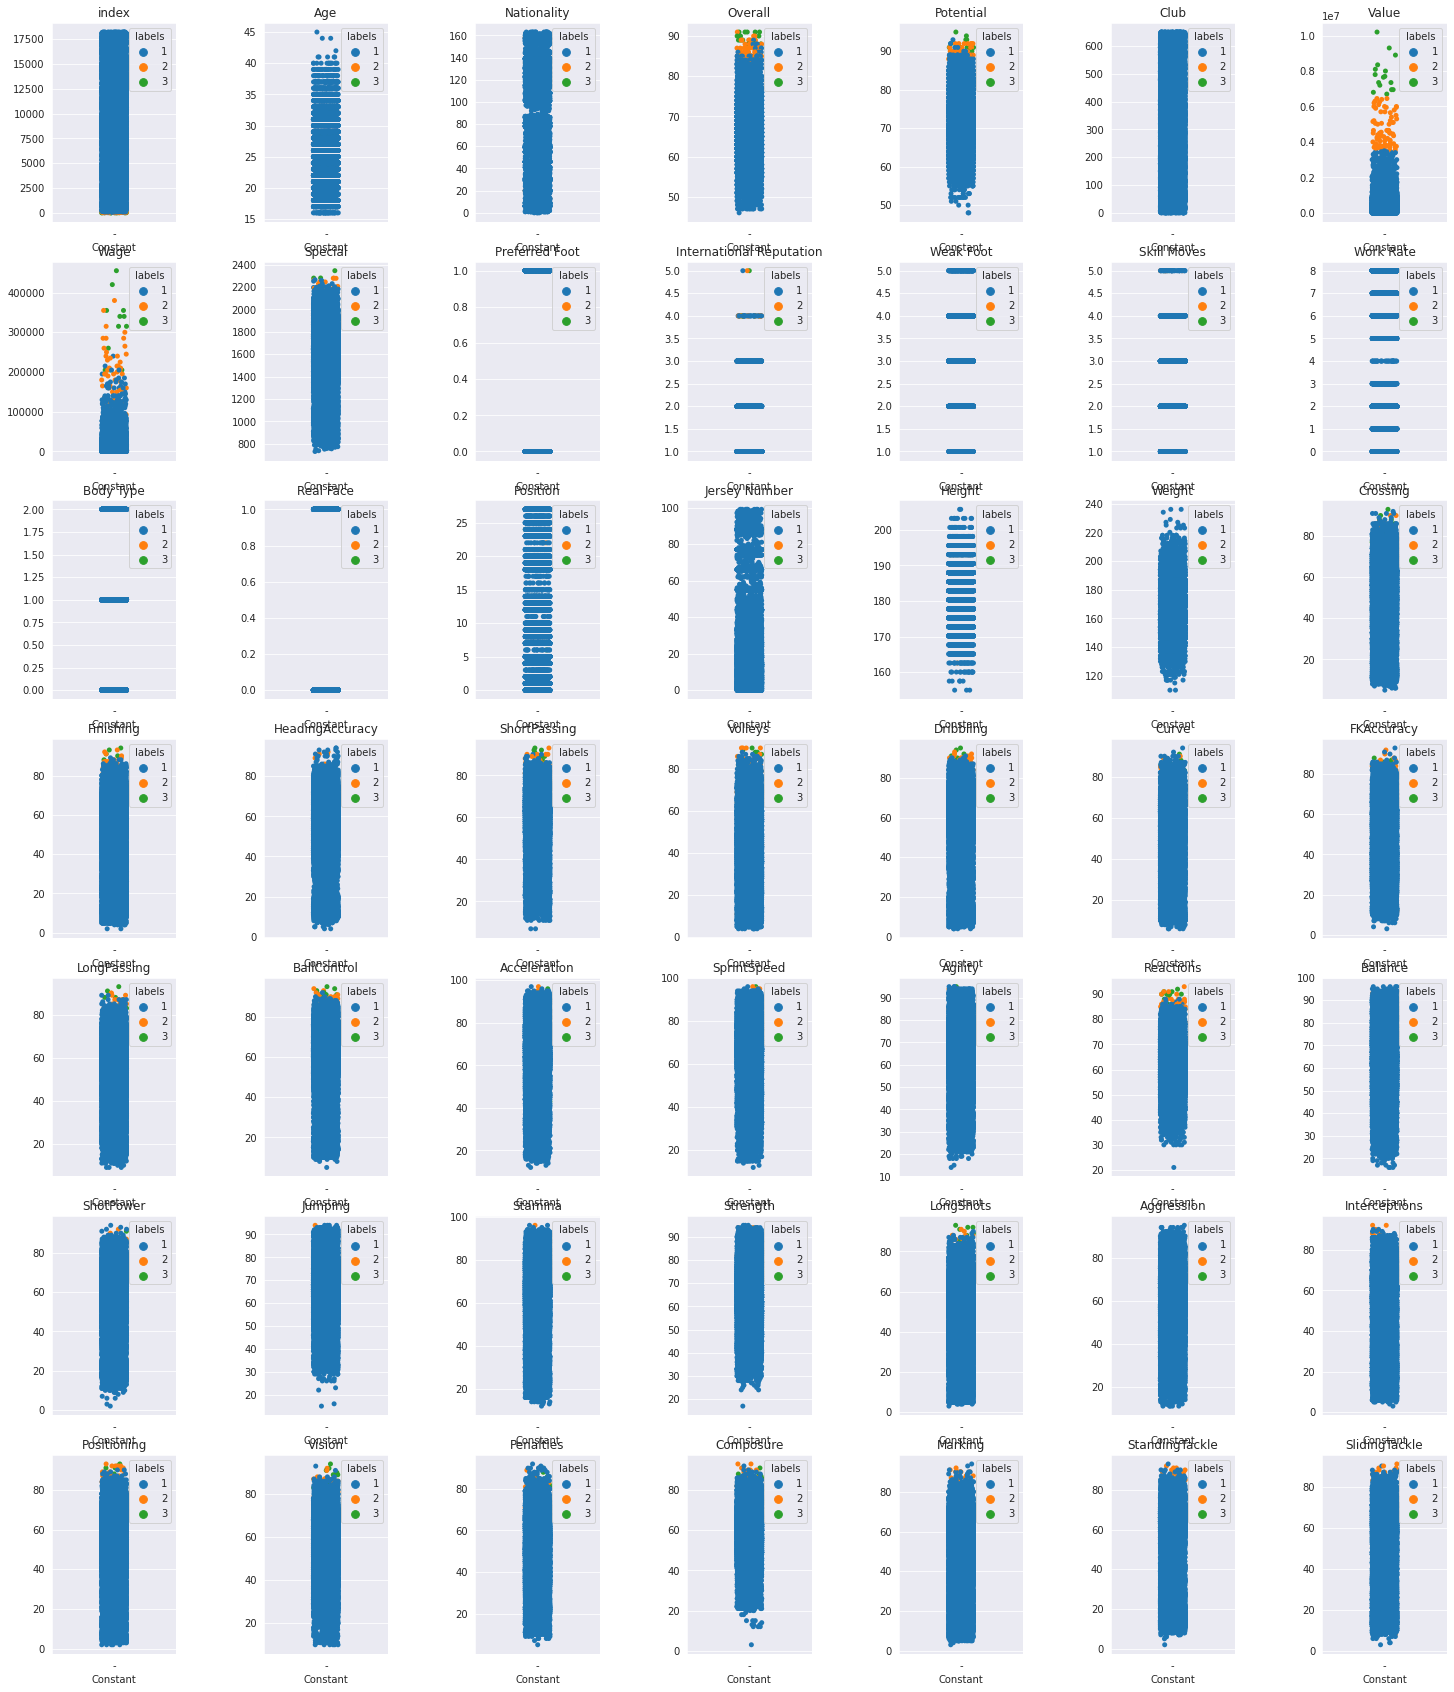

In [67]:
f, axes = plt.subplots(7, 7, figsize=(25, 30), sharex=False) #create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
f.subplots_adjust(hspace=0.2, wspace=0.7) #Scooch em apart, give em some room
#In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
for i in range(0,len(list(labeled_data))-2): #minus two because I don't want to plot labels or constant
    col = labeled_data.columns[i]
    if i < 7:
        ax = sns.stripplot(x=labeled_data['Constant'],y=labeled_data[col].values,hue=labeled_data['labels'],jitter=True,ax=axes[0,(i)])
        ax.set_title(col)
    elif i >= 7 and i<14:
        ax = sns.stripplot(x=labeled_data['Constant'],y=labeled_data[col].values,hue=labeled_data['labels'],jitter=True,ax=axes[1,(i-7)]) #so if i=6 it is row 1 column 1
        ax.set_title(col)
    elif i >= 14 and i<21:
        ax = sns.stripplot(x=labeled_data['Constant'],y=labeled_data[col].values,hue=labeled_data['labels'],jitter=True,ax=axes[2,(i-14)])
        ax.set_title(col)
    elif i >= 21 and i<28:
        ax = sns.stripplot(x=labeled_data['Constant'],y=labeled_data[col].values,hue=labeled_data['labels'],jitter=True,ax=axes[3,(i-21)])
        ax.set_title(col)
    elif i >= 28 and i<35:
        ax = sns.stripplot(x=labeled_data['Constant'],y=labeled_data[col].values,hue=labeled_data['labels'],jitter=True,ax=axes[4,(i-28)])
        ax.set_title(col)
    elif i >= 35 and i<42:
        ax = sns.stripplot(x=labeled_data['Constant'],y=labeled_data[col].values,hue=labeled_data['labels'],jitter=True,ax=axes[5,(i-35)])
        ax.set_title(col)
    elif i >= 42 and i<49:
        ax = sns.stripplot(x=labeled_data['Constant'],y=labeled_data[col].values,hue=labeled_data['labels'],jitter=True,ax=axes[6,(i-42)])
        ax.set_title(col)